In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [6]:
# Constants 
DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
OUT_PATH=DATA_PATH+'/results/fig_simu.rv1'

# Trait info 
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
DF_TRAIT_SS_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.UKB_subsample.tsv', sep='\t', index_col=0)

DF_TRAIT_145K_INFO = pd.read_excel('/n/holystore01/LABS/price_lab/Lab/ldsc/sumstats_formatted/Description.xlsx',
                                   sheet_name=1)
DF_TRAIT_145K_INFO.index = DF_TRAIT_145K_INFO['Trait_Identifier']
temp_df = pd.read_excel('/n/holystore01/LABS/price_lab/Lab/ldsc/sumstats_formatted/Description.xlsx',
                        sheet_name=0)
temp_df.index = temp_df['Trait_Identifier']
DF_TRAIT_145K_INFO = DF_TRAIT_145K_INFO.join(temp_df[['N']])

# Set score file 
DIC_SCORE_PATH = {
    'full' : DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore',
#     'ukb145k' : DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore_UKB145K_26trait',
    'ss' : DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore_UKB_subsample',
}

# Subsample parameters 
UKB_TRAIT_LIST = [
    x.split('.subsample_300K')[0] for x in os.listdir(DIC_SCORE_PATH['ss']) if 'subsample_300K' in x]
SUBSAMPLE_LIST = [10, 30, 100, 300]

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['full'] = UKB_TRAIT_LIST.copy()
# DIC_TRAIT_LIST['ukb145k'] = [
#     x.replace('.score.gz','') for x in os.listdir(DIC_SCORE_PATH['ukb145k']) if x.endswith('score.gz')]
DIC_TRAIT_LIST['ss'] = [
    x.replace('.score.gz','') for x in os.listdir(DIC_SCORE_PATH['ss']) if x.endswith('score.gz')]
for score in DIC_TRAIT_LIST:
    print('{:^20s} {:^20s}'.format(score, 'n_trait=%d'%len(DIC_TRAIT_LIST[score])))
    
# MAGMA
DIC_MAGMA = {}
DIC_MAGMA['full'] = pd.read_csv(
    '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/MAGMA-v108/'
    'MAGMA_v108_GENE_10_ZSTAT_for_scDRS.txt', sep='\t')
# DIC_MAGMA['ukb145k'] = DIC_MAGMA['full'][DIC_TRAIT_LIST['ukb145k']].copy()
DIC_MAGMA['ss'] = pd.read_csv(
    '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/MAGMA-v108/'
    'MAGMA_v108_GENE_10_ZSTAT_for_scDRS_subsampled_refmt.txt', sep='\t', index_col=0)

        full              n_trait=35     
         ss              n_trait=140     


In [7]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)   

### Analysis

In [28]:
# Power
df_stats = pd.DataFrame(columns=[
    'res', 'trait', 'n_sample', 'h2g', 'h2g_z', 'log10_me', 
    'n_sig', 'prop_zg3', 'score_q001', 'score_q005', 'score_q01', 'corr_full',
], dtype=float)

# Full data UKB460K 
for trait in UKB_TRAIT_LIST:
    df_stats.loc[trait] = [
        'full', trait, 460, #DF_TRAIT_INFO.loc[trait, 'N'], 
        DF_TRAIT_INFO.loc[trait, 'h2g'], 
        DF_TRAIT_INFO.loc[trait, 'Z'], 
        DF_TRAIT_INFO.loc[trait, 'log10 Me Common'], 
        (dic_score['full']['%s.fdr'%trait]<0.1).sum(),
        (dic_score['full']['%s.norm_score'%trait]>3).mean(),
        np.quantile(dic_score['full']['%s.norm_score'%trait], 0.999),
        np.quantile(dic_score['full']['%s.norm_score'%trait], 0.995),
        np.quantile(dic_score['full']['%s.norm_score'%trait], 0.99),
        1, 
    ]
print('UKB 460K: N=%d-%d \t n_trait=%d'%(
    DF_TRAIT_INFO.loc[UKB_TRAIT_LIST, 'N'].min(),
    DF_TRAIT_INFO.loc[UKB_TRAIT_LIST, 'N'].max(),
    len(UKB_TRAIT_LIST)
))
    
# # UKB145K 
# for trait_145k in DIC_TRAIT_LIST['ukb145k']:
#     trait = trait_145k.replace('UKB2_145K', 'UKB_460K')
#     df_stats.loc[trait_145k] = [
#         'UKB_145K', trait, 145, #DF_TRAIT_145K_INFO.loc[trait_145k, 'N'], 
#         DF_TRAIT_INFO.loc[trait, 'h2g'], 
#         DF_TRAIT_145K_INFO.loc[trait_145k, 'Z'], 
#         DF_TRAIT_INFO.loc[trait, 'log10 Me Common'], 
#         (dic_score['ukb145k']['%s.fdr'%trait_145k]<0.1).sum(),
#         (dic_score['ukb145k']['%s.norm_score'%trait_145k]>3).mean(),
#         np.quantile(dic_score['ukb145k']['%s.norm_score'%trait_145k], 0.999),
#         np.quantile(dic_score['ukb145k']['%s.norm_score'%trait_145k], 0.995),
#         np.quantile(dic_score['ukb145k']['%s.norm_score'%trait_145k], 0.99),
#         np.corrcoef(dic_score['ukb145k']['%s.norm_score'%trait_145k], 
#                     dic_score['full']['%s.norm_score'%trait])[0,1],
#     ]
# print('UKB 145K: N=%d-%d \t n_trait=%d'%(
#     DF_TRAIT_145K_INFO.loc[DIC_TRAIT_LIST['ukb145k'], 'N'].min(),
#     DF_TRAIT_145K_INFO.loc[DIC_TRAIT_LIST['ukb145k'], 'N'].max(),
#     len(DIC_TRAIT_LIST['ukb145k'])
# ))
    
# UKB_subsample  
for n in SUBSAMPLE_LIST:
    for trait in UKB_TRAIT_LIST:
        trait_ss = '%s.subsample_%dK'%(trait, n)
        df_stats.loc[trait_ss] = [
            'ss', trait, n, 
            DF_TRAIT_INFO.loc[trait, 'h2g'], 
            DF_TRAIT_SS_INFO.loc[trait_ss, 'Z'], 
            DF_TRAIT_INFO.loc[trait, 'log10 Me Common'], 
            (dic_score['ss']['%s.fdr'%trait_ss]<0.1).sum(),
            (dic_score['ss']['%s.norm_score'%trait_ss]>3).mean(),
            np.quantile(dic_score['ss']['%s.norm_score'%trait_ss], 0.999),
            np.quantile(dic_score['ss']['%s.norm_score'%trait_ss], 0.995),
            np.quantile(dic_score['ss']['%s.norm_score'%trait_ss], 0.99),
            np.corrcoef(dic_score['ss']['%s.norm_score'%trait_ss], 
                        dic_score['full']['%s.norm_score'%trait])[0,1],
        ]
        
# Postprocessing
df_stats['n_sample'] = df_stats['n_sample'].astype(int)
df_stats['log10_nsig'] = np.log10(df_stats['n_sig']+1)
ind_select = ~df_stats['log10_me'].isna()
df_stats.loc[ind_select, 'log10_me'] = [float(x.split(' (')[0]) for x in df_stats.loc[ind_select, 'log10_me']]
df_stats['log10_me'] = df_stats['log10_me'].astype(float)

bins_ = [0,5,10,15,20,np.inf]
df_stats['h2g_z_bin'] = pd.cut(df_stats['h2g_z'], bins_)

UKB 460K: N=411840-459324 	 n_trait=35


h2g_z_bin.log10_nsig.all: n_trait=35, AIT, ALP, ALT, ASM, BMD-HT, BMI, BMR, Breast cancer, CVD, DBP, ECOL, EOS, EY, Eczema, HT, HTN, Hair color, HbA1c, Height, LDL, LYM, MCH, MONO, NCH, PLT, RBC, RDW, RR-ENT, SBP, Smoking, TBIL, TC, TG, WBC, WHR


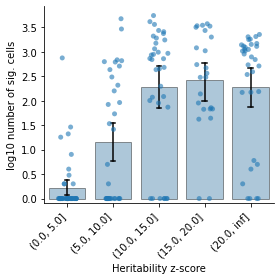

n_sample.log10_nsig.all: n_trait=35, AIT, ALP, ALT, ASM, BMD-HT, BMI, BMR, Breast cancer, CVD, DBP, ECOL, EOS, EY, Eczema, HT, HTN, Hair color, HbA1c, Height, LDL, LYM, MCH, MONO, NCH, PLT, RBC, RDW, RR-ENT, SBP, Smoking, TBIL, TC, TG, WBC, WHR


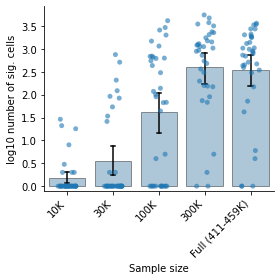

h2g_z_bin.log10_nsig.h2g: n_trait=35
All traits: AIT, ALP, ALT, ASM, BMD-HT, BMI, BMR, Breast cancer, CVD, DBP, ECOL, EOS, EY, Eczema, HT, HTN, Hair color, HbA1c, Height, LDL, LYM, MCH, MONO, NCH, PLT, RBC, RDW, RR-ENT, SBP, Smoking, TBIL, TC, TG, WBC, WHR
h2g Low: n_trait=18, AIT, ALT, ASM, Breast cancer, CVD, ECOL, EY, Eczema, HT, HTN, Hair color, LDL, NCH, RR-ENT, Smoking, TBIL, TC, TG
h2g High: n_trait=17, ALP, BMD-HT, BMI, BMR, DBP, EOS, HbA1c, Height, LYM, MCH, MONO, PLT, RBC, RDW, SBP, WBC, WHR


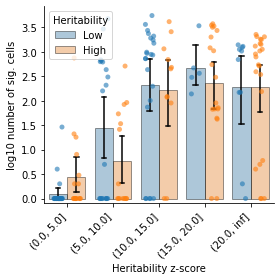

h2g_z_bin.log10_nsig.log10_me: n_trait=14
All traits: AIT, ASM, BMD-HT, BMI, ECOL, EOS, Eczema, Height, NCH, RBC, RDW, SBP, Smoking, WBC
log10_me Low: n_trait=7, AIT, ASM, BMD-HT, EOS, Eczema, RBC, RDW
log10_me High: n_trait=7, BMI, ECOL, Height, NCH, SBP, Smoking, WBC


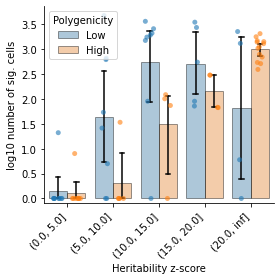

n_sample.log10_nsig.h2g: n_trait=35
All traits: AIT, ALP, ALT, ASM, BMD-HT, BMI, BMR, Breast cancer, CVD, DBP, ECOL, EOS, EY, Eczema, HT, HTN, Hair color, HbA1c, Height, LDL, LYM, MCH, MONO, NCH, PLT, RBC, RDW, RR-ENT, SBP, Smoking, TBIL, TC, TG, WBC, WHR
h2g Low: n_trait=18, AIT, ALT, ASM, Breast cancer, CVD, ECOL, EY, Eczema, HT, HTN, Hair color, LDL, NCH, RR-ENT, Smoking, TBIL, TC, TG
h2g High: n_trait=17, ALP, BMD-HT, BMI, BMR, DBP, EOS, HbA1c, Height, LYM, MCH, MONO, PLT, RBC, RDW, SBP, WBC, WHR


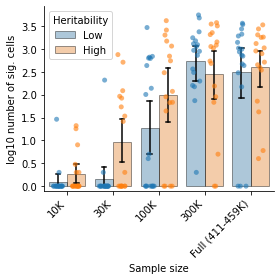

n_sample.log10_nsig.log10_me: n_trait=14
All traits: AIT, ASM, BMD-HT, BMI, ECOL, EOS, Eczema, Height, NCH, RBC, RDW, SBP, Smoking, WBC
log10_me Low: n_trait=7, AIT, ASM, BMD-HT, EOS, Eczema, RBC, RDW
log10_me High: n_trait=7, BMI, ECOL, Height, NCH, SBP, Smoking, WBC


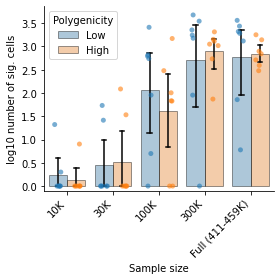

In [75]:
DIC_NAME = {
    'h2g_z_bin' : 'Heritability z-score',
    'n_sample' : 'Sample size',
    'log10_nsig' : 'log10 number of sig. cells',
    'h2g' : 'Heritability',
    'log10_me' : 'Polygenicity',
#     145 : 'UKB2 (134-146K)',
    460 : 'Full (411-459K)'
}

x = 'h2g_z_bin'
y = 'log10_nsig'

# All 
for x in ['h2g_z_bin', 'n_sample']:        
    plt.figure(figsize=[4,4])
    ax = plt.subplot(1,1,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # df_plot
    ind_select = (df_stats['res']!='UKB_145K')
    df_plot = df_stats.loc[ind_select].copy()
    trait_list = list(set(df_plot['trait']))
    print('%s.%s.all: n_trait=%d, %s'
          %(x,y,len(trait_list), ', '.join(sorted([DF_TRAIT_INFO.loc[x, 'Code'] for x in trait_list]))))

    # Plot
    sns.barplot(data=df_plot, x=x, y=y, color='C0', 
                edgecolor="black", errcolor="black", errwidth=1.5, capsize = 0.1, alpha=0.4)
    sns.stripplot(data=df_plot, x=x, y=y, color='C0', alpha=0.6, jitter=0.2)
    ymin,ymax = plt.ylim()
    plt.ylim([-0.1, ymax])

    if x == 'h2g_z_bin':
        cat_list = list(df_plot[x].cat.categories)
        plt.xticks(np.arange(len(cat_list)), cat_list, rotation=45, ha='right')
    if x == 'n_sample':
        cat_list = sorted(df_plot[x].unique())
        cat_list = [DIC_NAME[x] if x in [145,460] else '%sK'%x for x in cat_list] 
        plt.xticks(np.arange(len(cat_list)), cat_list, rotation=45, ha='right')

    plt.xlabel(DIC_NAME[x])
    plt.ylabel(DIC_NAME[y])

    plt.tight_layout()
    plt.savefig(OUT_PATH+'/UKB_ss.%s.%s.all.svg'%(x,y))
    plt.show()

# Stratified 
for x in ['h2g_z_bin', 'n_sample']:        
    for term in ['h2g', 'log10_me']:
        plt.figure(figsize=[4,4])
        ax = plt.subplot(1,1,1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # df_plot
        ind_select = ~df_stats[term].isna()
        ind_select = ind_select & (df_stats['res']!='UKB_145K')
        df_plot = df_stats.loc[ind_select].copy()
        print('%s.%s.%s: n_trait=%d'%(x,y,term,len(set(df_plot['trait']))))
        
        # Stratum
        stratum = DIC_NAME[term]
        df_plot[stratum] = ''
        qbin = pd.qcut(df_plot[term], 2, labels=False)
        df_plot.loc[qbin==0, stratum] = 'Low'
        df_plot.loc[qbin==1, stratum] = 'High'
        
        trait_list = list(set(df_plot['trait']))
        print('All traits: %s'%', '.join(sorted([DF_TRAIT_INFO.loc[x, 'Code'] for x in trait_list])))
        for cat in ['Low', 'High']:
            trait_list = list(set(df_plot.loc[df_plot[stratum]==cat, 'trait']))
            print('%s %s: n_trait=%d, %s'
                  %(term, cat, len(trait_list),
                    ', '.join(sorted([DF_TRAIT_INFO.loc[x, 'Code'] for x in trait_list]))
                   ))
        
        # Plot
        sns.barplot(data=df_plot, x=x, y=y, hue=stratum, hue_order=['Low', 'High'], 
                    edgecolor="black", errcolor="black", errwidth=1.5, capsize = 0.1, alpha=0.4)
        sns.stripplot(data=df_plot, x=x, y=y, hue=stratum, hue_order=['Low', 'High'], 
                      dodge=True, alpha=0.6, jitter=0.2)
        ymin,ymax = plt.ylim()
        plt.ylim([-0.1, ymax])
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[2:], labels[2:], title=stratum)
        
        if x == 'h2g_z_bin':
            cat_list = list(df_plot[x].cat.categories)
            plt.xticks(np.arange(len(cat_list)), cat_list, rotation=45, ha='right')
        if x == 'n_sample':
            cat_list = sorted(df_plot[x].unique())
            cat_list = [DIC_NAME[x] if x in [145,460] else '%sK'%x for x in cat_list] 
            plt.xticks(np.arange(len(cat_list)), cat_list, rotation=45, ha='right')
            
        plt.xlabel(DIC_NAME[x])
        plt.ylabel(DIC_NAME[y])

        plt.tight_layout()
        plt.savefig(OUT_PATH+'/UKB_ss.%s.%s.%s.svg'%(x,y,term))
        plt.show()